In [1]:
import os
import random
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import math
from scipy import spatial
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import sys
from skimage.measure import compare_ssim,compare_mse

random.seed(datetime.now())
os.chdir('/home/cilegann/Documents/TB')
os.getcwd()

'/home/cilegann/Documents/TB'

In [2]:
database='./data'
dirs=['negative','positive','polluted']

In [3]:
def getGroup(str):
    return str[:str.find("_")]
def getDateStr(str):
    if '/' in str:
        str=str[str.rfind('/'):]
    return str[str.find("_")+1:str.find(".")]
def getDate(str):
    return datetime.strptime(getDateStr(str), "%Y%m%d").date()

In [4]:
samples={}
print("+++ Start building info +++")
for r,ds,fs in os.walk(database):
    for f in fs:
        path=os.path.join(r,f)
        group=getGroup(f)
        if 'txt' not in f and 'jpg' in f and 'smote' not in r:
            if len(group)!=1 and group!='discrete':
                if group not in samples:
                    samples[group]={'files':[],'result':0,'duration':0,'length':0,'type':'sample','firstdate':None}
                samples[group]['files'].append(path)
            else:
                samples[f]={'files':[path],'result':0,'duration':1,'length':1,'type':'discrete','firstdate':None}
                if 'positive' in path:
                    samples[f]['result']=1
                if 'polluted' in path:
                    samples[f]['result']=2
print("+++ Building info done +++")

+++ Start building info +++
+++ Building info done +++


In [5]:
print("+++ Start sorting +++")
for k,v in samples.items():
    samples[k]['files']=sorted(samples[k]['files'],key=lambda x:getDateStr(x))
print("+++ Sorting done +++")

+++ Start sorting +++
+++ Sorting done +++


In [6]:
print("+++ Start computing duration and length +++")
for k,v in (samples.items()):
    if samples[k]['type']=="sample":
        samples[k]['duration']=(getDate(samples[k]['files'][-1])-getDate(samples[k]['files'][0])).days+1
        samples[k]['length']=len(samples[k]['files'])
        samples[k]['firstdate']=getDate(samples[k]['files'][0])
        if 'positive' in samples[k]['files'][-1]:
            samples[k]['result']=1
        if 'polluted' in samples[k]['files'][-1]:
            samples[k]['result']=2
print("+++ Computing duration and length done +++")

+++ Start computing duration and length +++
+++ Computing duration and length done +++


In [7]:
negative={}
d_positive={}
s_positive={}
positive={}
polluted={}
for k,v in (samples.items()):
    if samples[k]['result']==0:
        negative[k]=samples[k]
    elif samples[k]['result']==1:
        if v['type']=='discrete':
            d_positive[k]=samples[k]
        else:
            s_positive[k]=samples[k]
        positive[k]=samples[k]
    elif samples[k]['result']==2:
        polluted[k]=samples[k]

In [9]:
#ratios=[0.3,0.35,0.4,0.5,0.6,0.7,0.8,0.9]
ratios=np.arange(0.3, 0.95, 0.1)
times=1
mse_result=[]
ssim_result=[]
discarded_length_result=[]
origin_length_result=[]
train_length_result=[]

for r in ratios:
    total_mses=0
    total_ssims=0
    total_discarded=0
    total_origin=0
    total_train=0
    print("======================")
    print("Ratio:",r)
    
    for time in (range(times)):
        mses=0
        ssims=0
        origin=0
        train=0
        vali_negative_groups=random.sample(set(negative),100)
        vali_dpositive_groups=random.sample(set(d_positive),21)
        vali_spositive_groups=random.sample(set(s_positive),79)
        vali_positive_groups=vali_dpositive_groups+vali_spositive_groups
        vali_polluted_groups=random.sample(set(polluted),100)
        vali_groups=vali_negative_groups+vali_positive_groups+vali_polluted_groups
        train_len_percentile=r
        tv_pairs=[]
        cnt=[0,0,0]
        for k,v in samples.items():
            total_origin+=len(v['files'])
            if k in vali_groups and v['type']!='discrete':
                vali_file=v['files'][-1]
                files=v['files'][:-1]
                remainder_len=len(files)
                train_len=math.ceil(remainder_len*train_len_percentile)
                total_discarded+=(remainder_len-train_len)
                cnt[v['result']]+=(remainder_len-train_len)
                total_train+=train_len
#                 tv_pairs.append((vali_file,files[max(train_len-1,0)]))
                if v['result']!=0:
                    tv_pairs.append((vali_file,files[train_len-1]))
            elif k not in vali_groups:
                total_train+=len(v['files'])
        for pair in tv_pairs:
            v=np.asarray(Image.open(pair[0]))
            t=np.asarray(Image.open(pair[1]))
            s=compare_ssim(v,t,multichannel=True)
            d=compare_mse(v,t)
#             v=v.reshape(-1)
#             t=t.reshape(-1)
#             v=v/255.
#             t=t/255.
#             d=np.linalg.notm(v - t)
            mses+=(d)
            ssims+=(s)
        mses/=len(tv_pairs)
        ssims/=len(tv_pairs)
        total_mses+=mses
        total_ssims+=ssims
    print(cnt)
    total_train/=times
    total_origin/=times
    total_discarded/=times
    total_mses/=times
    total_ssims/=times
    mse_result.append(total_mses)
    ssim_result.append(total_ssims)
    discarded_length_result.append(total_discarded)
    origin_length_result.append(total_origin)
    train_length_result.append(total_train)
    print("orig len:",total_origin)
    print("train len:",total_train)
    print("discard len:",total_discarded)
    print("mse:",total_mses)
    print("ssim:",total_ssims)

Ratio: 0.3
[565, 483, 540]
orig len: 16503.0
train len: 14615.0
discard len: 1588.0
mse: 690.9974551743494
ssim: 0.807687124040314
Ratio: 0.4
[504, 411, 430]
orig len: 16503.0
train len: 14858.0
discard len: 1345.0
mse: 585.4976980301735
ssim: 0.820498572597979
Ratio: 0.5
[460, 350, 365]
orig len: 16503.0
train len: 15028.0
discard len: 1175.0
mse: 495.1587119467391
ssim: 0.8312090772703961
Ratio: 0.6000000000000001
[328, 256, 269]
orig len: 16503.0
train len: 15350.0
discard len: 853.0
mse: 408.6396227745526
ssim: 0.8500731822054639
Ratio: 0.7000000000000002
[251, 184, 194]
orig len: 16503.0
train len: 15574.0
discard len: 629.0
mse: 382.21040327696625
ssim: 0.8509308634344839
Ratio: 0.8000000000000003
[138, 106, 111]
orig len: 16503.0
train len: 15848.0
discard len: 355.0
mse: 347.97522902232356
ssim: 0.8600133390105814
Ratio: 0.9000000000000001
[39, 30, 29]
orig len: 16503.0
train len: 16105.0
discard len: 98.0
mse: 256.9580977777824
ssim: 0.8837197906165949


In [10]:
ssim_result_n = [float(i)/max(ssim_result) for i in ssim_result]
mse_result_n = [float(i)/max(mse_result) for i in mse_result]
train_length_result_n=[float(i)/max(train_length_result) for i in train_length_result]
discarded_length_result_n=[float(i)/max(discarded_length_result) for i in discarded_length_result]

ssim_discarded=[(s*d) for s,d in zip(ssim_result_n,discarded_length_result_n)]
ssim_discarded_ratio=[(s*(d/o)) for s,d,o in zip(ssim_result,discarded_length_result,origin_length_result)]
ssim_train=[(s/t) for s,t in zip(ssim_result_n,train_length_result_n)]
ssim_train_ratio=[(s/(t/o)) for s,t,o in zip(ssim_result,train_length_result,origin_length_result)]

mse_discarded=[(d/m) for m,d in zip(mse_result_n,discarded_length_result_n)]
mse_discarded_ratio=[((d/o)/m) for m,d,o in zip(mse_result,discarded_length_result,origin_length_result)]
mse_train=[(1/(m*t)) for m,t in zip(mse_result_n,train_length_result_n)]
mse_train_ratio=[(1/(m*(t/o))) for m,t,o in zip(mse_result,train_length_result,origin_length_result)]



fuck_you_ratio=[((s*d)/(m*t)) for s,d,m,t in zip(ssim_result_n,discarded_length_result_n,mse_result_n,train_length_result_n)]



In [11]:
ratios

array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [12]:
ssim_train

[1.0071414912677454,
 1.0063837694109032,
 1.007987714954279,
 1.009239137541994,
 0.9957269315433068,
 0.9889557797350222,
 1.0]

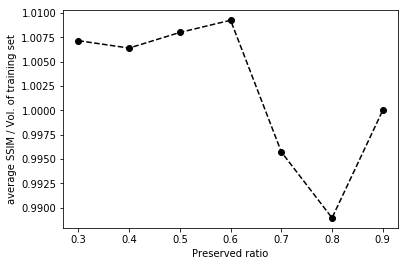

In [16]:
plt.xlabel("Preserved ratio")
plt.ylabel("average SSIM / Vol. of training set")
plt.plot( ratios,ssim_train,'--bo',color='black')
plt.savefig('ratio.png', dpi=300,bbox_inches='tight')

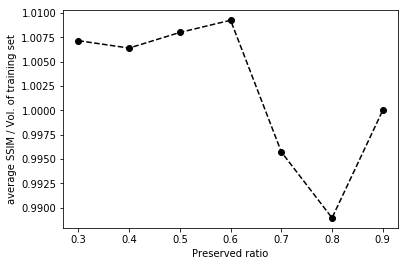

In [5]:
ssim_train=[1.0071414912677454,
 1.0063837694109032,
 1.007987714954279,
 1.009239137541994,
 0.9957269315433068,
 0.9889557797350222,
 1.0]
ratios=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.xlabel("Preserved ratio")
plt.ylabel("average SSIM / Vol. of training set")
plt.plot( ratios,ssim_train,'--bo',color='black')
plt.savefig('ratio.svg', bbox_inches='tight',format='svg')

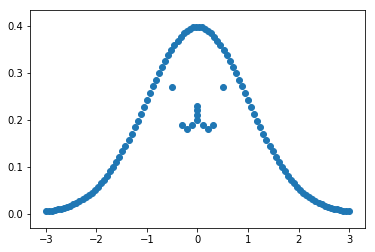

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y=stats.norm.pdf(x, mu, sigma)
x=list(x)
y=list(y)
x.extend([-0.5,0.5,0,-0.1,0.1,-0.2,0.2,-0.3,0.3,0,0,0])
y.extend([0.27,0.27,0.2,0.19,0.19,0.18,0.18,0.19,0.19,0.21,0.22,0.23])
plt.scatter(x, y)
plt.show()